In [9]:
import pandas as pd
import csv

# Load the large CSV file in chunks
large_file_path = '/content/all_data.csv'
output_subset_path = '/content/all_data_subset.csv'

# Set the number of rows to sample (e.g., 10,000)
sample_size = 10000

# Use pandas to sample and save the smaller dataset
# The 'error_bad_lines' argument has been replaced with 'on_bad_lines'.
# Setting 'on_bad_lines' to 'warn' will issue a warning for bad lines
# but will continue processing.
# *Change:* Added engine='python' to force using the Python parser
# *Change:* Added quoting=csv.QUOTE_NONE to handle unescaped quotes
# *Change:* Added encoding='latin-1' to handle potential encoding issues
chunk_iter = pd.read_csv(large_file_path, chunksize=100000, on_bad_lines='warn', engine='python', quoting=csv.QUOTE_NONE, escapechar='\\', encoding='latin-1')
sampled_data = pd.concat([chunk.sample(n=min(len(chunk), sample_size), random_state=42) for chunk in chunk_iter])

# Save the subset to a new file
sampled_data.to_csv(output_subset_path, index=False)
print(f"Subset saved to {output_subset_path}")

Streaming output truncated to the last 5000 lines.

  sampled_data = pd.concat([chunk.sample(n=min(len(chunk), sample_size), random_state=42) for chunk in chunk_iter])
<ipython-input-9-506fccfe3c87>:19: ParserWarning: Skipping line 538834: Expected 46 fields in line 538834, saw 47

  sampled_data = pd.concat([chunk.sample(n=min(len(chunk), sample_size), random_state=42) for chunk in chunk_iter])
<ipython-input-9-506fccfe3c87>:19: ParserWarning: Skipping line 538835: Expected 46 fields in line 538835, saw 53

  sampled_data = pd.concat([chunk.sample(n=min(len(chunk), sample_size), random_state=42) for chunk in chunk_iter])
<ipython-input-9-506fccfe3c87>:19: ParserWarning: Skipping line 538836: Expected 46 fields in line 538836, saw 54

  sampled_data = pd.concat([chunk.sample(n=min(len(chunk), sample_size), random_state=42) for chunk in chunk_iter])
<ipython-input-9-506fccfe3c87>:19: ParserWarning: Skipping line 538839: Expected 46 fields in line 538839, saw 47

  sampled_data = pd.conc

Subset saved to /content/all_data_subset.csv


In [11]:
import pandas as pd
import re

# Load the sampled subset
subset_file_path = '/content/all_data_subset.csv'
data = pd.read_csv(subset_file_path)
print(f"Loaded subset shape: {data.shape}")

Loaded subset shape: (130000, 46)


<ipython-input-11-e16027242c9f>:6: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(subset_file_path)


In [12]:
# Clean Text Data
def clean_text(text):
    text = str(text).lower()  # Ensure text is lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
    return text
data['cleaned_text'] = data['comment_text'].apply(clean_text)


In [13]:
# Create Binary Labels
# Convert 'toxicity' column to numeric, handling errors
data['toxicity'] = pd.to_numeric(data['toxicity'], errors='coerce')
data['label'] = (data['toxicity'] >= 0.5).astype(int)

In [14]:
# Save Processed Data
processed_file_path = '/content/processed_subset.csv'
data[['cleaned_text', 'label']].to_csv(processed_file_path, index=False)
print(f"Processed data saved to {processed_file_path}")

Processed data saved to /content/processed_subset.csv


In [21]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd

# Load your dataset
data = pd.read_csv("/content/processed_subset.csv")  # Replace with your file path
# Change 'text' to 'cleaned_text' in the subset argument
data = data.dropna(subset=['cleaned_text', 'label'])  # Ensure no missing values

In [22]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(data['cleaned_text'], data['label'], test_size=0.2, random_state=42)

# Initialize Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [29]:
# Define Dataset Class
class ToxicityDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128): # Corrected _init_ to __init__
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): # Changed _len_ to __len__
        return len(self.texts)

    def __getitem__(self, idx): # Changed _getitem_ to __getitem__
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [30]:
# Prepare DataLoaders
train_dataset = ToxicityDataset(X_train, y_train, tokenizer)
val_dataset = ToxicityDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)



In [31]:
# Initialize DistilBERT Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
# Training Loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")


Epoch 1, Loss: 0.1147756929531076
Epoch 2, Loss: 0.08348002501720876
Epoch 3, Loss: 0.05812725301213908


In [33]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming val_loader is your DataLoader for the validation set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Validation Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     20371
           1       0.70      0.65      0.67      1397

    accuracy                           0.96     21768
   macro avg       0.84      0.82      0.83     21768
weighted avg       0.96      0.96      0.96     21768



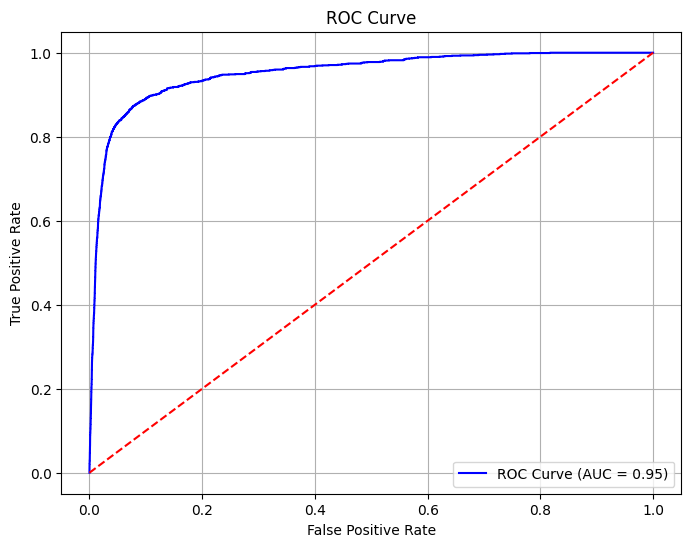

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize empty lists to store all predictions and probabilities
all_preds = []
all_probs = []
all_labels = []

# Assuming val_loader is your DataLoader for the validation set
model.eval()

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)[:, 1]  # Get probabilities for class 1

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # Store probabilities for ROC curve
        all_labels.extend(labels.cpu().numpy())

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)  # Use all_probs instead of val_preds_proba
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

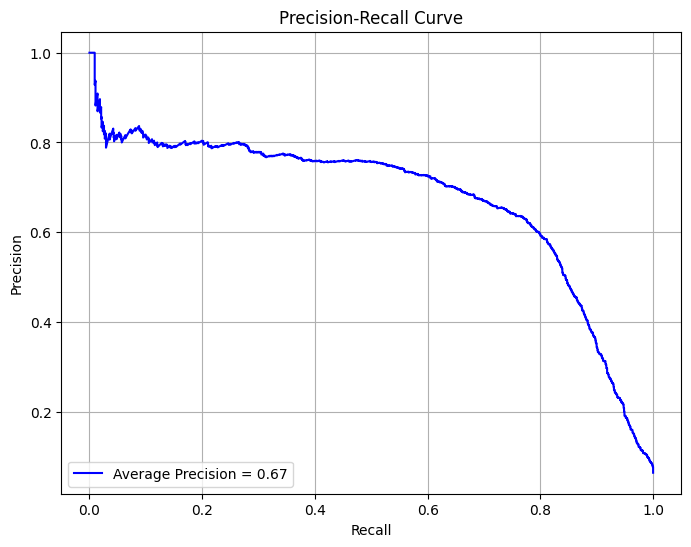

In [37]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize empty lists to store all predictions and probabilities
all_preds = []
all_probs = []
all_labels = []

# Assuming val_loader is your DataLoader for the validation set
model.eval()

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)[:, 1]  # Get probabilities for class 1

        all_probs.extend(probs.cpu().numpy())  # Store probabilities for ROC curve
        all_labels.extend(labels.cpu().numpy())

# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs) # Use all_probs instead of val_preds_proba[:, 1]
average_precision = average_precision_score(all_labels, all_probs) # Use all_probs instead of val_preds_proba[:, 1]

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Average Precision = {average_precision:.2f}', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid()
plt.show()